### Basic Chatbot with LangGraph(GraphAPI)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)



In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")


In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000199BDFB9010>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000199BDFB9BE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000199BE071A90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000199BE072490>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)

graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

graph=graph_builder.compile()


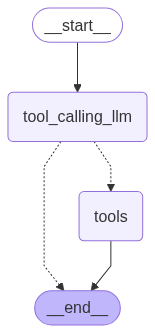

In [48]:
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [15]:
for event in graph.stream({"messages": "How are you?  "}):
	for value in event.values():
		print(value["messages"][-1].content)

I'm just a language model, I don't have feelings or emotions like humans do. I'm functioning properly and ready to help you with any questions or tasks you have. Is there something specific you'd like to chat about or ask?


### Chatbot with tools

In [6]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgrapg")

{'query': 'What is langgrapg',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling complex

In [16]:
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): The first number.
        b (int): The second number.

    Returns:
        int: The product of a and b.
    """
    return a*b

In [17]:
tools=[tool,multiply]

In [18]:
llm_with_tool=llm.bind_tools(tools)

In [19]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002655011D010>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002655011DBE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

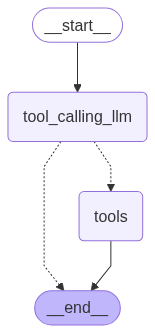

In [32]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph=builder.compile()

from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [33]:
response=graph.invoke({"messages":"What is the recent tech news?"})

In [35]:
response["messages"][-1].content

'{"query": "recent tech news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4041372/uks-colt-hit-by-cyberattack-support-systems-offline-amid-ransom-threat.html", "title": "UK’s Colt hit by cyberattack, support systems offline amid ransom threat - csoonline.com", "score": 0.5889134, "published_date": "Mon, 18 Aug 2025 12:12:50 GMT", "content": "news ### ECScape: New AWS ECS flaw lets containers hijack IAM roles without breaking out Aug 8, 2025 4 mins\\n   news ### ‘We too were breached,’ says Google, months after revealing Salesforce attacks Aug 7, 2025 4 mins\\n   news ### Akira affiliates abuse legitimate Windows drivers to evade detection in SonicWall attacks Aug 6, 2025 4 mins\\n   news ### Nvidia patches critical Triton server bugs that threaten AI model security Aug 5, 2025 4 mins [...] news ### Flaws in a pair of Grafana plugins could hand over DevOps control Aug 14, 2025 5 mins\\n   news ### Hackers exploit unp

In [47]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  multiply (3jcw0nzr8)
 Call ID: 3jcw0nzr8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [45]:
response=graph.invoke({"messages":"What is 2 multiply by 3 and then multiply 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  multiply (3jcw0nzr8)
 Call ID: 3jcw0nzr8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


### React Agent

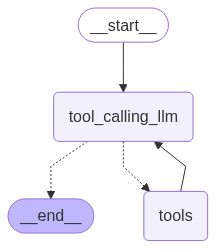

In [50]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()

from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [52]:
response=graph.invoke({"messages":"What is 2 multiply by 3 and then multiply 10 and tell me the latest news in ai"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3 and then multiply 10 and tell me the latest news in ai
================================== Ai Message ==================================
Tool Calls:
  multiply (9reetcx0j)
 Call ID: 9reetcx0j
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  multiply (rvfc98ykd)
 Call ID: rvfc98ykd
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

60
================================== Ai Message ==================================
Tool Calls:
  tavily_search (94tbhsrcb)
 Call ID: 94tbhsrcb
  Args:
    query: latest news in ai
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news in ai", "fol

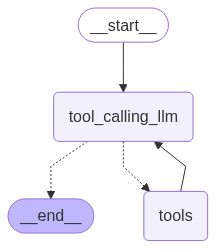

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile(checkpointer=memory)

from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Deep"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Deep', additional_kwargs={}, response_metadata={}, id='3111fa5f-56f8-4d4c-a7c1-b5514670913a'),
  AIMessage(content='Nice to meet you, Deep! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 2869, 'total_tokens': 2884, 'completion_time': 0.018092536, 'prompt_time': 0.328193064, 'queue_time': 0.266426192, 'total_time': 0.3462856}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0868a611-f597-4b01-8828-feee939ca5ec-0', usage_metadata={'input_tokens': 2869, 'output_tokens': 15, 'total_tokens': 2884})]}

In [60]:
response["messages"][-1].content

'Nice to meet you, Deep! How can I assist you today?'

In [61]:
response=graph.invoke({"messages":"What is my name?"},config=config)

In [62]:
response["messages"][-1].content

'Your name is Deep.'

In [64]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is Deep', additional_kwargs={}, response_metadata={}, id='3111fa5f-56f8-4d4c-a7c1-b5514670913a'), AIMessage(content='Nice to meet you, Deep! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 2869, 'total_tokens': 2884, 'completion_time': 0.018092536, 'prompt_time': 0.328193064, 'queue_time': 0.266426192, 'total_time': 0.3462856}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0868a611-f597-4b01-8828-feee939ca5ec-0', usage_metadata={'input_tokens': 2869, 'output_tokens': 15, 'total_tokens': 2884}), HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='49131320-31b9-4f5a-aa8c-9c0f95ca5e46'), AIMessage(content='Your name is Deep.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens